In [2]:
# Install specific libraries
! pip install transformers
! pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [4]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Amazon_Products.csv")

data.dropna(subset=['Body'], inplace=True)
data.dropna(subset=['Title'], inplace=True)

data.head(5)

,ASIN,Product,Title,Rating,Date,Body,Brand
0,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Great product,5,22 February 2020,This is a brilliant product...I'd had the Tefa...,Princess
1,B0741D7LRD,"Princess 182050 Digital air Fryer, Black","I love mine, pity the non stick coating comes ...",1,25 June 2019,"I love mine, pity the non stick coating comes ...",Princess
2,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Digital programming broke down,1,21 March 2019,Thought this product would be great but had it...,Princess
3,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Perfect,5,4 July 2022,This is my second one of these the 1st lasted ...,Smartwares
4,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Great item,5,22 February 2022,Great item,Smartwares


In [6]:
data['Sentiment'] = data['Rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
data['label'] = data['Sentiment'].apply(lambda x: 1 if x=="positive" else 0)
data['Text'] = data['Body'] + data['Title']
data['id'] = np.arange(data.shape[0])
data.head(5)


,ASIN,Product,Title,Rating,Date,Body,Brand,Sentiment,label,Text,id
0,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Great product,5,22 February 2020,This is a brilliant product...I'd had the Tefa...,Princess,positive,1,This is a brilliant product...I'd had the Tefa...,0
1,B0741D7LRD,"Princess 182050 Digital air Fryer, Black","I love mine, pity the non stick coating comes ...",1,25 June 2019,"I love mine, pity the non stick coating comes ...",Princess,negative,0,"I love mine, pity the non stick coating comes ...",1
2,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Digital programming broke down,1,21 March 2019,Thought this product would be great but had it...,Princess,negative,0,Thought this product would be great but had it...,2
3,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Perfect,5,4 July 2022,This is my second one of these the 1st lasted ...,Smartwares,positive,1,This is my second one of these the 1st lasted ...,3
4,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Great item,5,22 February 2022,Great item,Smartwares,positive,1,Great itemGreat item,4


<Axes: xlabel='Sentiment', ylabel='count'>

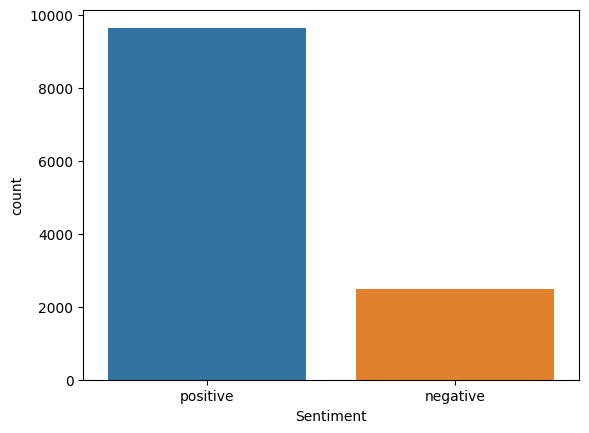

In [11]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='Sentiment', data=data)

In [12]:
data.groupby('label').count()

,ASIN,Product,Title,Rating,Date,Body,Brand,Sentiment,Text,id
label,,,,,,,,,,
0,2473,2473,2473,2473,2473,2473,2473,2473,2473,2473
1,9645,9645,9645,9645,9645,9645,9645,9645,9645,9645


In [13]:
import nltk
import re
nltk.download('stopwords')

from nltk.corpus import stopwords

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(data['Text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [15]:
y = data['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

([<matplotlib.patches.Wedge at 0x7f6052be7d90>,
 [Text(-0.7177173957648095, -0.961707720576569, 'positive'),
  Text(0.717717440785597, 0.9617076869777913, 'negative')],
 [Text(-0.41866848086280556, -0.5609961703363319, '79.6%'),
  Text(0.41866850712493153, 0.5609961507370449, '20.4%')])

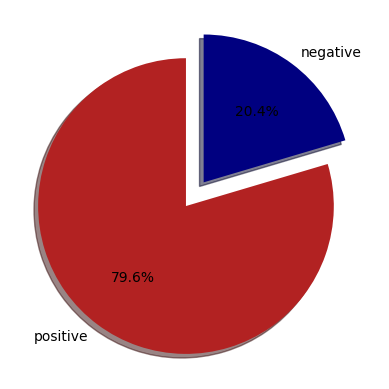

In [16]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['positive','negative'],autopct='%1.1f%%')

In [17]:

# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['Text'], data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data['Sentiment'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

BERT Fine-tuning

In [18]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Number of texts')

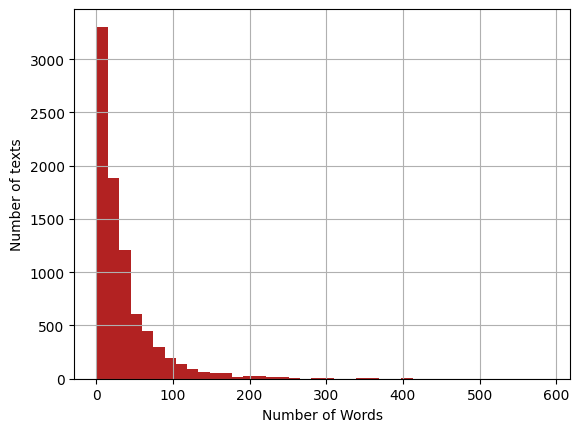

In [19]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [20]:
# BERT Tokeizer Functionality
sample_data = ["Build sentiment model.", 
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 15792, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0]]}


In [21]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 100
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [22]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [23]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [24]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [25]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 2

In [26]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [22]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.

Evaluating...
  Batch    50  of     57.

Training Loss: 0.507
Validation Loss: 0.482

 Epoch 2 / 2
  Batch    50  of    266.
  Batch   100  of    266.
  Batch   150  of    266.
  Batch   200  of    266.
  Batch   250  of    266.

Evaluating...
  Batch    50  of     57.

Training Loss: 0.482
Validation Loss: 0.471


In [27]:
# load weights of best model
path = '/content/c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [28]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       371
           1       0.80      1.00      0.89      1447

    accuracy                           0.80      1818
   macro avg       0.40      0.50      0.44      1818
weighted avg       0.63      0.80      0.71      1818



In [31]:
reviews = data["Text"].values.tolist()

reviews = reviews[:100]

reviews
#type(reviews)

["This is a brilliant product...I'd had the Tefal actifry previously and it's been a godsend as our oven brokeGreat product",
 "I love mine, pity the non stick coating comes off. It cooks very well, good quality, but let down by the non stick scratching too easily.UPDATED to one star as I cannot find a spare basketI love mine, pity the non stick coating comes off and you can't buy a replacement",
 'Thought this product would be great but had it few weeks and the digital program isn’t working already so gona have to go backDigital programming broke down',
 'This is my second one of these the 1st lasted 6 years so if this does the same I’ll be well happyPerfect',
 'Great itemGreat item',
 'The instruction manual was hard to understand and I did not like the 2 prong plug.  It did not arrive with cook book as stated on the website.  So I returned this on 2nd January and still have not heard anything from you, even though I have requested a phone call.  Very disappointed!!!Should have an ea

In [35]:
# testing on unseen data

unseen_review_text = ["This is bad",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]
"""
unseen_review_text = reviews
"""

# tokenize and encode sequences in the test set
MAX_LENGHT = 100

tokens_unseen = tokenizer.batch_encode_plus(
    unseen_review_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 1, 1])

In [29]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 807.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does not

In [30]:
!pip install transformers requests beautifulsoup4 pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [32]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [34]:
import numpy as np
import pandas as pd

In [35]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [38]:
sentiment_score(data['Text'].iloc[3])

5

In [1]:
data['bert_sentiment'] = data['Text'].apply(lambda x: sentiment_score(x[:46]))

NameError: ignored